# Feature Selection
---
In machine learning and statistics, feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for mainly four reasons:
- simplification of models to make them easier to interpret by researchers/users
- shorter training times
- to avoid the curse of dimensionality
- enhanced generalization by reducing overfitting (by reducing variance)

Features gathered from the observation of a phenomenon are not all equally
informative: some of them may be noisy, correlated or irrelevant. Feature
selection aims at selecting a feature set that is relevant for a given task. This
problem is complex and remains an important issue in many domains. 

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc 

# relevant feature selection libraries
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

In [2]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## Loading the data
---

In [3]:
USE_DUMMY_DATA = False
DUMMY_OBS = 25000  # 5000, 10000 or 25000

if not USE_DUMMY_DATA: 
    data_train = np.load(ROOT_PATH + "data/scaled/data_scaled_train.npy")
else: 
    data_train = np.load(ROOT_PATH + "data/scaled/dummy/dummy_train_{0}.npy".format(DUMMY_OBS))
    

headers = pd.read_csv(ROOT_PATH+"data/metadata/tags_all_chosen.csv", 
                      sep=";", keep_default_na=False, header=None).values[:,0]
target_tags = pd.read_csv(ROOT_PATH+"data/metadata/tags_targets.csv", 
                          sep=";", keep_default_na=False, header=None).values[:,0]
    
x_train = data_train[:,len(target_tags):]
y_train = data_train[:,:len(target_tags)]

print(data_train.shape, x_train.shape, y_train.shape)

(53211, 117) (53211, 114) (53211, 3)


---
## (1) Feature Selection by the Boruta Algorithm
---
Boruta is an all relevant feature selection method, while most other are minimal optimal; this means it tries to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some classifier has a minimal error. The Boruta algorithm is a Random Forest classification algorithm that we'll use to perform a top-down search for relevant features by comparing original attributes' importance with importance achievable at random, estimated using their permuted copies, and progressively eliminating irrelevant features.

In [4]:
def run_boruta(X, y, ntrees=500):
    forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=SEED)
    feat_selector = BorutaPy(forest, n_estimators=ntrees, verbose=2, random_state=SEED, max_iter=100)
    feat_selector.fit(X,y)
    
    return forest, feat_selector

In [ ]:
flow_forest, flow_boruta = run_boruta(x_train, y_train[:,0])
temp_forest, temp_boruta = run_boruta(x_train, y_train[:,1])
pres_forest, pres_boruta = run_boruta(x_train, y_train[:,2])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	114
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	114
Rejected: 	0


In [253]:
print("Confirmed for FT:",sum(flow_boruta.support_))
print("Confirmed for TT:",sum(temp_boruta.support_))
print("Confirmed for PT:",sum(pres_boruta.support_))

Confirmed for FT: 8
Confirmed for TT: 8
Confirmed for PT: 20


In [273]:
confirmed_ft = headers[3:][flow_boruta.support_]
confirmed_tt = headers[3:][temp_boruta.support_]
confirmed_pt = headers[3:][pres_boruta.support_]

def get_equal_elems(list1, list2):
    count = 0
    for e1 in list1: 
        if e1 in list2: count += 1
            
    return count

print("\n----- Confirmed tags for FT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_ft)]
print("\nEqual tags to TT:", get_equal_elems(confirmed_ft, confirmed_tt))
print("Equal tags to PT:", get_equal_elems(confirmed_ft, confirmed_pt))
print()

print("----- Confirmed tags for TT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_tt)]
print("\nEqual tags to FT:", get_equal_elems(confirmed_tt, confirmed_ft))
print("Equal tags to PT:", get_equal_elems(confirmed_tt, confirmed_pt))
print()

print("----- Confirmed tags for PT -----")
[print("{0}. {1}".format(i,tag)) for i,tag in enumerate(confirmed_pt)]
print("\nEqual tags to FT:", get_equal_elems(confirmed_pt, confirmed_ft))
print("Equal tags to TT:", get_equal_elems(confirmed_pt, confirmed_tt))
print()


----- Confirmed tags for FT -----
0. VAL_23-KA-9101-M01-62B:X.Value
1. VAL_23-KA-9101_ASP:VALUE
2. VAL_23-KA-9101_ESP:VALUE
3. VAL_23-TIC-92604B:Z.Y.Value
4. VAL_23_FT_92537_02:Z.X.Value
5. VAL_23_FT_92537_03:Z.X.Value
6. VAL_23_KA_9101_M01_62C:Z.X.Value
7. VAL_23_PIC_92538_06:Z.X.Value

Equal tags to TT: 0
Equal tags to PT: 3

----- Confirmed tags for TT -----
0. VAL_23-TIC-92604B:Z.X.Value
1. VAL_23-TT-92533:X.Value
2. VAL_23-TT-92537:X.Value
3. VAL_23-TT-92602:X.Value
4. VAL_23-TT-92604A:X.Value
5. VAL_23_TT_92532:Z.X.Value
6. VAL_23_TT_92536:Z.X.Value
7. VAL_45-TT-92607A:X.Value

Equal tags to FT: 0
Equal tags to PT: 2

----- Confirmed tags for PT -----
0. VAL_23-KA-9101_ASP:VALUE
1. VAL_23-KA-9101_ESP:VALUE
2. VAL_23-PDI-96150:X.Value
3. VAL_23-PDI-96249:X.Value
4. VAL_23-PDT-96146:X.Value
5. VAL_23-PT-92504:X.Value
6. VAL_23-PT-92512:X.Value
7. VAL_23-PT-92521:X.Value
8. VAL_23-PT-92523:X.Value
9. VAL_23-PT-92536:X.Value
10. VAL_23-PT-92540:X.Value
11. VAL_23-TIC-92604B:Z.X.Valu

In [250]:
# make dictionary
ranked_tags = {}
for i in range(x_train.shape[-1]):
    ranked_tags[headers[i]] = {"FT": flow_boruta.ranking_[i],
                               "TT": temp_boruta.ranking_[i],
                               "PT": pres_boruta.ranking_[i]}

# sort the dictionary
def keyfunc(tup):
    key, d = tup
    return d["TT"], d["FT"], d["PT"]

sorted_items = sorted(ranked_tags.items(), key = keyfunc)
sorted_items

[('VAL_45-TT-92506:X.Value', {'FT': 28, 'TT': 1, 'PT': 13}),
 ('VAL_23-TIC-96147:Z.X.Value', {'FT': 42, 'TT': 1, 'PT': 60}),
 ('VAL_23-TE-96137-02:X.Value', {'FT': 59, 'TT': 1, 'PT': 1}),
 ('VAL_23-TT-92537:X.Value', {'FT': 64, 'TT': 1, 'PT': 1}),
 ('VAL_23-TT-92512:X.Value', {'FT': 69, 'TT': 1, 'PT': 80}),
 ('VAL_23_PIC_92538_12:Z.X.Value', {'FT': 90, 'TT': 1, 'PT': 60}),
 ('VAL_23-TT-92502:X.Value', {'FT': 90, 'TT': 1, 'PT': 80}),
 ('VAL_23_PT_92531:Z.X.Value', {'FT': 98, 'TT': 1, 'PT': 60}),
 ('VAL_23-PT-96157:Z.X1.Value', {'FT': 65, 'TT': 2, 'PT': 50}),
 ('VAL_23-KA-9101_EPH:VALUE', {'FT': 80, 'TT': 2, 'PT': 5}),
 ('VAL_23-KA-9101_EPR:VALUE', {'FT': 80, 'TT': 2, 'PT': 21}),
 ('VAL_23-TIC-92604B:Z.X.Value', {'FT': 80, 'TT': 2, 'PT': 22}),
 ('VAL_23_YT_96134_01:Z.X.Value', {'FT': 80, 'TT': 2, 'PT': 36}),
 ('VAL_45-PT-92608:X.Value', {'FT': 94, 'TT': 2, 'PT': 70}),
 ('VAL_23-PT-96186:Z.X2.Value', {'FT': 98, 'TT': 2, 'PT': 70}),
 ('VAL_23-KA-9101_ASP:VALUE', {'FT': 25, 'TT': 3, 'PT': 7

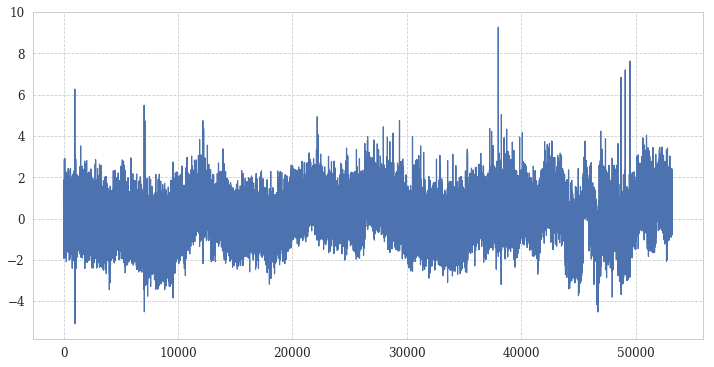

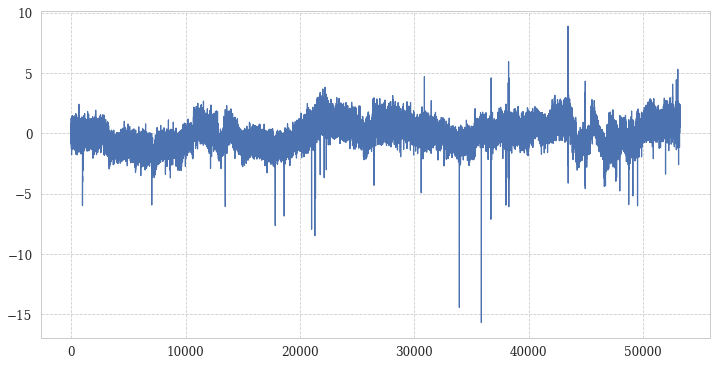

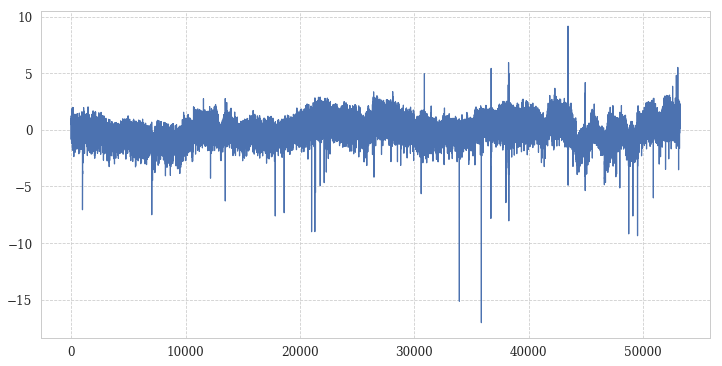

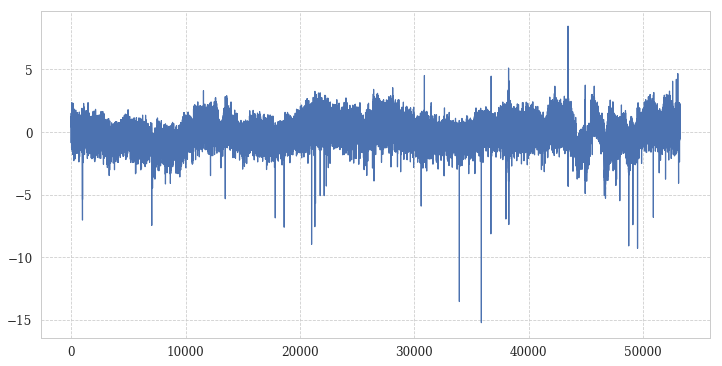

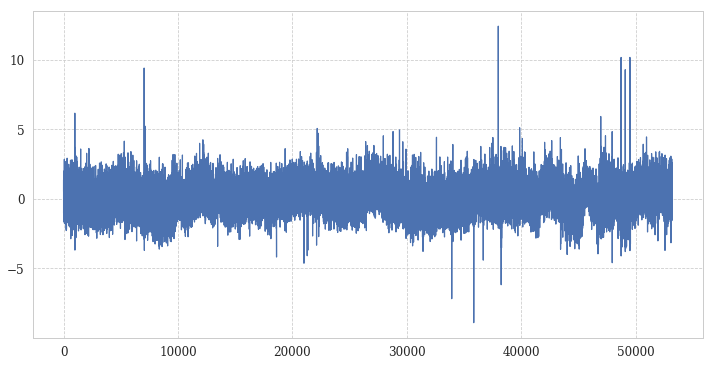

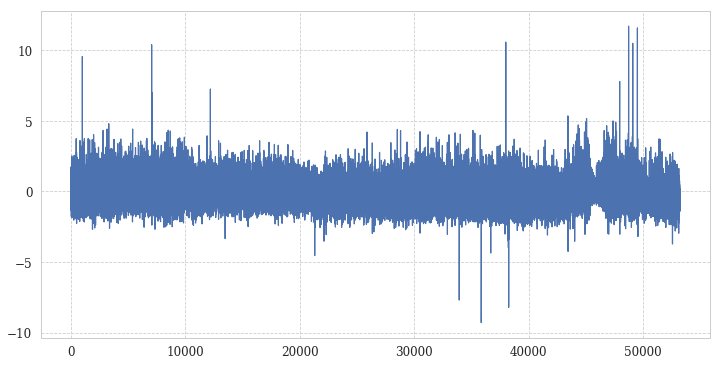

In [6]:
tags = ["VAL_23-KA-9101-M01-62B:X.Value",
        "VAL_23-KA-9101_APE:VALUE",
        "VAL_23-KA-9101_APH:VALUE",
        "VAL_23-KA-9101_APR:VALUE",
        "VAL_23-KA-9101_ASP:VALUE",
        "VAL_23-KA-9101_ESP:VALUE"]

for i, tag in enumerate(tags): 
    tag_idx = np.where(headers == tag)[0][0]  
    plt.figure()
    plt.plot(data_train[:,tag_idx])
    plt.show()

In [23]:
data = x_train[:,confirmed_idxs]
df = pd.DataFrame(data, columns=confirmed_inputs)
df.corr(method="pearson")

,VAL_23-KA-9101-M01-62B:X.Value,VAL_23-KA-9101_APE:VALUE,VAL_23-KA-9101_APH:VALUE,VAL_23-KA-9101_APR:VALUE,VAL_23-KA-9101_ASP:VALUE,VAL_23-KA-9101_ESP:VALUE,VAL_23-PDI-96149:X.Value,VAL_23-PDI-96150:X.Value,VAL_23-PDT-96167:X.Value,VAL_23-PT-92504:X.Value,...,VAL_23_FT_92537_03:Z.X.Value,VAL_23_KA_9101_M01_62C:Z.X.Value,VAL_23_PIC_92538_04:Z.X.Value,VAL_23_PIC_92538_06:Z.X.Value,VAL_23_PIC_92538_08:Z.X.Value,VAL_23_PIC_92538_12:Z.X.Value,VAL_23_PT_92531:Z.X.Value,VAL_23_PT_92537:Z.X.Value,VAL_23_TT_92536:Z.X.Value,VAL_23_ZT_92543:Z.X.Value
VAL_23-KA-9101-M01-62B:X.Value,1.000000,-0.091514,0.124749,-0.275713,-0.282602,0.342995,0.251110,0.187749,-0.319961,-0.464144,...,-0.385213,0.192655,-0.472227,-0.472204,0.062612,0.234894,0.275809,0.344783,0.350641,0.474135
VAL_23-KA-9101_APE:VALUE,-0.091514,1.000000,-0.225214,-0.521714,-0.520108,0.544208,0.392431,0.334522,-0.076681,0.406991,...,0.550186,0.813907,0.359780,0.359769,0.377637,-0.032241,-0.013074,0.400809,0.345910,0.276000
VAL_23-KA-9101_APH:VALUE,0.124749,-0.225214,1.000000,0.596992,0.586972,-0.457450,-0.136156,-0.263725,0.165018,0.156190,...,-0.081011,-0.249555,0.184852,0.184939,0.206892,-0.148825,-0.049100,-0.210044,-0.197333,-0.274251
VAL_23-KA-9101_APR:VALUE,-0.275713,-0.521714,0.596992,1.000000,0.999850,-0.936324,-0.370451,-0.521894,0.330847,0.450031,...,-0.047622,-0.478799,0.502559,0.502599,0.374258,-0.334006,-0.170369,-0.445130,-0.425013,-0.653998
VAL_23-KA-9101_ASP:VALUE,-0.282602,-0.520108,0.586972,0.999850,1.000000,-0.937783,-0.374956,-0.522631,0.332022,0.454093,...,-0.044552,-0.478116,0.506556,0.506595,0.374701,-0.339605,-0.175980,-0.446713,-0.426818,-0.659038
VAL_23-KA-9101_ESP:VALUE,0.342995,0.544208,-0.457450,-0.936324,-0.937783,1.000000,0.393113,0.475788,-0.325743,-0.488007,...,-0.061910,0.415950,-0.535947,-0.535974,-0.385919,0.348458,0.342493,0.502447,0.430941,0.652300
VAL_23-PDI-96149:X.Value,0.251110,0.392431,-0.136156,-0.370451,-0.374956,0.393113,1.000000,0.212969,-0.168119,0.081281,...,0.109522,0.519798,0.050323,0.050281,0.225207,0.603742,0.547967,0.351745,0.368924,0.638303
VAL_23-PDI-96150:X.Value,0.187749,0.334522,-0.263725,-0.521894,-0.522631,0.475788,0.212969,1.000000,-0.178977,-0.142614,...,0.165321,0.410209,-0.180300,-0.180323,-0.093780,0.159288,0.058327,0.337745,0.319091,0.397105
VAL_23-PDT-96167:X.Value,-0.319961,-0.076681,0.165018,0.330847,0.332022,-0.325743,-0.168119,-0.178977,1.000000,0.261440,...,0.134919,-0.148793,0.273803,0.273815,0.096508,-0.240454,-0.203206,-0.350938,-0.281810,-0.317666
VAL_23-PT-92504:X.Value,-0.464144,0.406991,0.156190,0.450031,0.454093,-0.488007,0.081281,-0.142614,0.261440,1.000000,...,0.701648,0.439681,0.997467,0.997473,0.823146,-0.270905,-0.234135,-0.093845,-0.084846,-0.355223


In [9]:
confirmed_inputs = pd.read_csv(ROOT_PATH+"data/metadata/feature-selection/features_boruta.csv", 
                               sep=";", keep_default_na=False, header=None).values[:,0]

confirmed_idxs = sorted([np.where(headers == tag)[0][0] for tag in confirmed_inputs])
print(confirmed_idxs)

[9, 10, 11, 12, 13, 17, 28, 29, 40, 44, 45, 46, 47, 48, 49, 50, 51, 76, 77, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 103]


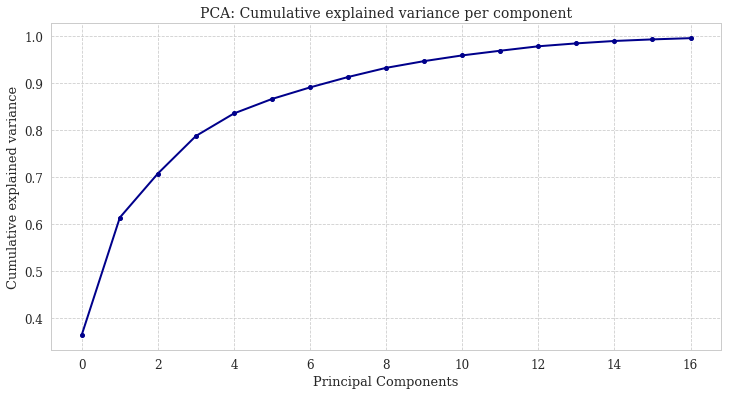

In [19]:
from sklearn.decomposition import PCA
pca = PCA(17).fit(x_train[:,confirmed_idxs])

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o", c="darkblue", ms=4, lw=2)
plt.title("PCA: Cumulative explained variance per component")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative explained variance")
plt.show()

(53211, 17)


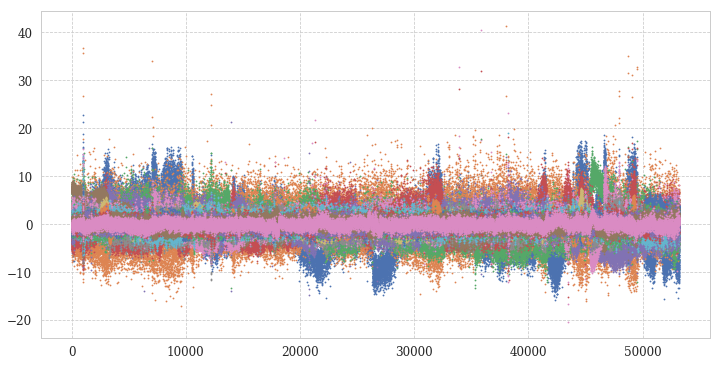

In [25]:
x_train_pca = pca.fit_transform(x_train)
print(x_train_pca.shape)

for i in range(pca.n_components_):
    plt.scatter(range(len(x_train)), x_train_pca[:,i], s=1)
plt.show()

---
## (2) Feature Selection by Random Forest
---

In [7]:
params_rf = {'n_estimators': 1000, 
             'max_depth': 5, 
             'min_samples_split': 2, 
             'max_features': 'auto', 
             'random_state': 0, 
             'n_jobs': -1, 
             'oob_score': True,
             'verbose': 1
            }
rf = RandomForestRegressor(**params_rf)

In [8]:
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=0, verbose=1, warm_start=False)

In [9]:
avg_imp = np.average(rf.feature_importances_)
avg_imp_gt0 = np.average(rf.feature_importances_[rf.feature_importances_ > 0])
print("Average Imp.:          ", avg_imp)
print("Average Imp. > 0:      ", avg_imp_gt0)
print("Feature Imp. > 0:      ",len(rf.feature_importances_[rf.feature_importances_ > 0]))
print("#Feature Imp. > avg:   ",len(rf.feature_importances_[rf.feature_importances_ > avg_imp]))
print("#Feature Imp. > avg.>0:",len(rf.feature_importances_[rf.feature_importances_ > avg_imp_gt0]))

Average Imp.:           0.008771929824561405
Average Imp. > 0:       0.04347826086956523
Feature Imp. > 0:       23
#Feature Imp. > avg:    4
#Feature Imp. > avg.>0: 3


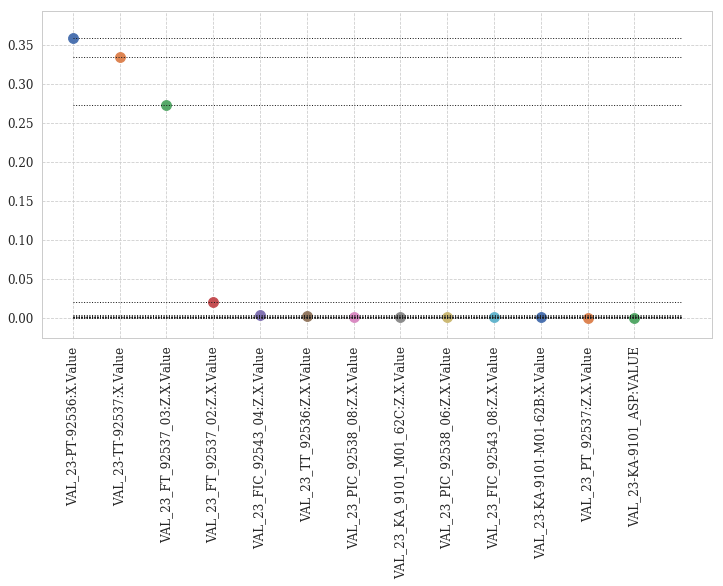

Most important features by Random Forest:


,Tag,Value
0,VAL_23-PT-92536:X.Value,0.358602
1,VAL_23-TT-92537:X.Value,0.334820
2,VAL_23_FT_92537_03:Z.X.Value,0.273366
3,VAL_23_FT_92537_02:Z.X.Value,0.020509
4,VAL_23_FIC_92543_04:Z.X.Value,0.003989
5,VAL_23_TT_92536:Z.X.Value,0.002210
6,VAL_23_PIC_92538_08:Z.X.Value,0.001607
7,VAL_23_KA_9101_M01_62C:Z.X.Value,0.001389
8,VAL_23_PIC_92538_06:Z.X.Value,0.001271
9,VAL_23_FIC_92543_08:Z.X.Value,0.000887


In [45]:
headers_imp = list(zip(headers[3:],rf.feature_importances_))
headers_imp_sorted = sorted(headers_imp, key=lambda tag: tag[1], reverse=True)
headers_imp_filtered = list(filter(lambda elem: elem[1] > 1e-4, headers_imp_sorted))

plt.figure()
for i in range(len(headers_imp_filtered)):
    tag, val = headers_imp_filtered[i]
    #plt.bar(x=i,height=val,label=tag)
    plt.scatter(x=i, y=val, label=tag, s=100)
    plt.hlines(y=val,xmin=0,xmax=len(headers_imp_filtered), linestyle="dotted", lw=1.0)

xticks = [tup[0] for tup in headers_imp_filtered]
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.show()

print("Most important features by Random Forest:")
df = pd.DataFrame({"Tag":   [tup[0] for tup in headers_imp_filtered], 
              "Value": [tup[1] for tup in headers_imp_filtered]})
df.sort_values(by=["Value", "Tag"], ascending=False)

In [46]:
# Save results
path = ROOT_PATH + "data/metadata/feature-selection/"
df["Tag"].to_csv(path + "features_rf.csv", index=False)